In [1]:
import numpy as np
import matplotlib.pyplot as plt
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.pinokla.calc_criterion import (ActuatedMass, ImfCompute, ManipCompute,
                                                      MovmentSurface, NeutralPoseMass, TranslationErrorMSE, EffectiveInertiaCompute, ManipJacobian)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (convert_x_y_to_6d_traj_xz,
                                                    get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import EndPointIMFReward, MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point

In [8]:
central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.2,50))


# criteria that either calculated without any reference to points, or calculated through
# the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ), # determinant of the jacobian
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(), # mass term in the dynamic equation with only actuated joints as generalized coordinates
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1), (EndPointIMFReward(imf_key='IMF',
            trajectory_key="traj_6d", error_key="error"), 1), (EndPointZRRReward(manipulability_key='Manip_Jacobian',
             trajectory_key="traj_6d", error_key="error"), 1), (MassReward(mass_key="MASS"), 1)]
step_trajectories = [central_vertical]

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

rewards_and_trajectories = [(rewards_step, step_trajectories)]

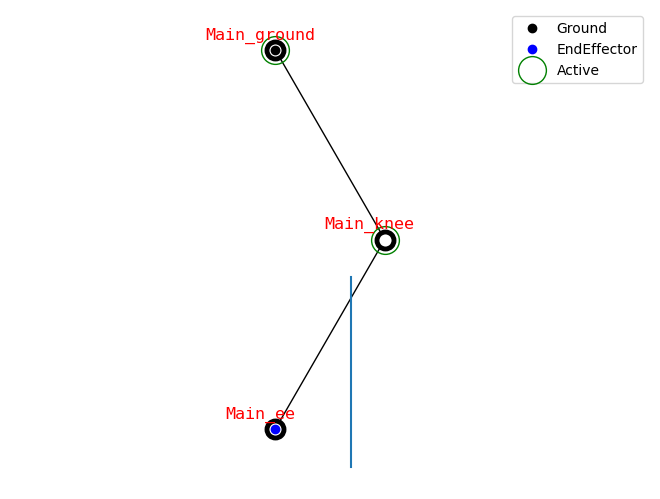

In [9]:
actuator_list = [TMotor_AK10_9()]
generator = TwoLinkGenerator()
generator.build_standard_two_linker()
graph = generator.graph

# open chain is fully actuated
for jp in graph.nodes:
    if not jp.attach_endeffector:
        jp.active = True

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

In [10]:
result_vector = {}
for j in actuator_list:
    # create builder
    thickness = 0.04
    builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*5, thickness*10, thickness*2]), actuator=j, thickness=thickness)

    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

    total_reward=0
    partial_rewards = []
    for rewards, trajectories in rewards_and_trajectories:
        max_reward = -float('inf')
        max_partial = None
        best_trajectory = None
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=j)[0])
                current_total += weight*current_partial[-1]
            if current_total > max_reward:
                max_reward = current_total
                max_partial = current_partial
                best_trajectory_id = trajectory_id
        total_reward+= max_reward
        partial_rewards.append((best_trajectory_id, max_partial))


    result_vector[j.__class__.__name__] = (total_reward, partial_rewards)

for keys,values in result_vector.items():
    print(keys)
    print(values)

TMotor_AK10_9
(28.358603997726522, [(0, [0, 27.185338808267808, 0.42036065459251404, 3.665222462992215, -2.912317928126016])])


In [11]:
point_criteria_vector["Manip_Jacobian"]


array([[[-1.1       , -0.5758199 ],
        [-0.2       ,  0.04200939]],

       [[-1.089796  , -0.5742376 ],
        [-0.2       ,  0.05987099]],

       [[-1.0795919 , -0.57235736],
        [-0.2       ,  0.07576533]],

       [[-1.0693878 , -0.57026297],
        [-0.2       ,  0.09018578]],

       [[-1.0591837 , -0.56800735],
        [-0.2       ,  0.10344549]],

       [[-1.0489796 , -0.56562656],
        [-0.2       ,  0.11575809]],

       [[-1.0387756 , -0.5631464 ],
        [-0.2       ,  0.12727709]],

       [[-1.0285715 , -0.5605863 ],
        [-0.2       ,  0.1381172 ]],

       [[-1.0183673 , -0.5579611 ],
        [-0.2       ,  0.14836682]],

       [[-1.0081632 , -0.55528283],
        [-0.2       ,  0.15809587]],

       [[-0.9979592 , -0.5525611 ],
        [-0.2       ,  0.16736066]],

       [[-0.9877551 , -0.54980385],
        [-0.2       ,  0.17620744]],

       [[-0.97755104, -0.54701793],
        [-0.2       ,  0.18467465]],

       [[-0.96734697, -0.54420906],
  

In [12]:
point_criteria_vector["Manip_Jacobian"][:,1,0]


array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,
       -0.2, -0.2, -0.2, -0.2, -0.2, -0.2], dtype=float32)

In [11]:
# double the size of the base
result_vector = {}
for j in actuator_list:
    # create builder
    thickness = 0.04
    
    builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*10, thickness*20, thickness*4]), actuator=j, thickness=thickness)

    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

    total_reward=0
    partial_rewards = []
    for rewards, trajectories in rewards_and_trajectories:
        max_reward = -float('inf')
        max_partial = None
        best_trajectory = None
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=j)[0])
                current_total += weight*current_partial[-1]
            if current_total > max_reward:
                max_reward = current_total
                max_partial = current_partial
                best_trajectory_id = trajectory_id
        total_reward+= max_reward
        partial_rewards.append((best_trajectory_id, max_partial))

    result_vector[j.__class__.__name__] = (total_reward, partial_rewards)


for keys,values in result_vector.items():
    print(keys)
    print(values)

TMotor_AK10_9
(44.62483050385717, [(0, [0, 45.51250083725724, 0.2801215648651123, 1.7445260298608294, -2.912317928126016])])


Mass of the base do not change the mass criterion (the last one)